# Bootleneck 

Después de haber entregado el análisis preliminar al cliente, en donde encontramos los valores del __flujo promedio limpio__ (en camiones por hora) para cada zona operacional, es momento de dar un vuelco y comenzar a procesar los datos conforme a encontrar patrones o indicadores de cuellos de botella dentro de CS. Para ello tomaremos la siguiente estructura.

1. Estructuración de los datos.
2. Calculo de estadísticos
3. Representación de estos. 

---

Para entender mejor la estructuración de los datos es necesario comprender ciertos objetivos y conceptos.

__Objetivo Principal__: Comprender el funcionamiento de la faena CS a través del análisis de los tiempos de espera y atención para cada Zona Operacional (ZO)

__Estrategia__: Buscar información en bloques de 30 minutos.

Tendremos 3 tipos de estatus:
1. Atención: cuando un camión se encuentra dentro de una ZO
2. Espera: cuando un camión está en espera o tránsito a una ZO
3. Out: Cuando el camión se encuentra fuera de la faena CS

Qué pretendemos encontrar en cada bloque establecido, para Atención y Espera?
1. N° de camiones que ingresaron y salieron de una ZO
2. N° de camiones que estaban en una ZO al inicio del bloque.
3. Tiempo acumulado de atención (SUM_i (t_i) = Tiempo acumulado).
4. Promedio, moda, media, max, min de tiempos de atención
5. Promedio, moda, media, max, min en el conteo de vehículos en Espera y Atención.

__Conceptos importantes__

1. __Tiempos de IDLE__: cuando tenemos una ZO inactiva y sin camiones en espera
2. __Tiempos de inactividad__: cuando tenemos una ZO inactiva y con camiones en espera
3. __Tiempos de Transición__: corresponden a los tiempos de salida y llegada de camiones (se estima que el máximo debe ser 5 min).


---

# 1. Estructuración de los datos 

Tomaremos en consideración los filtros aplicados en la sección de preprocesado, sin embargo añadiremos nuevas columnas omitidas en ese análisis, como lo son las columnas de "ZO Pre-Time", "ZO start", "ZO end" y quizás otra que consideremos importante para estos propósitos. 
Recordemos anteriormente que amparados en el análisis previo solamente consideraremos 8 ciclos, por lo que se eliminaran los cilos desde el 9 al 98.

Además, eliminamos los viajes que van desde CS a CS, es decir los camiones que se encuentran en la misma faena todo el tiempo, debido a que se escapan de nuestro análisis por el momento.

---
__Este fue el codigo usado para crear el dateset BottleNeck_filtered.csv__
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy import stats
    import datetime

    file = "SQMStats_CS_Bottleneck_20190101-20210101.csv"
    data = pd.read_csv(file ,quotechar="'",engine="python",encoding="utf-8")

    #Columnas a eliminar
    cols = ['Cycle Id','Quarter','Type','Fleet','Asset','Waybill','Product','Total time']
    zone_name = ['Zone Name (%s)'%x for x in range(9,99)]
    zone_start = ['Zone Start (%s)'%x for x in range(9,99)]
    zone_end = ['Zone End (%s)'%x for x in range(9,99)]
    zone_time = ['Zone Time (%s)'%x for x in range(9,99)]
    zone_pretime = ['Zone Pre Time (%s)'%x for x in range(9,99)]
    cols += zone_name + zone_start + zone_end + zone_time + zone_pretime
    df = data.drop(cols,axis=1)

    #Filtramos por CS-CS
    df = df.drop(df[(df.Origin == 'Coya Sur') & (df.Destination ==  'Coya Sur')].index)

    #Cambiamos los objetos str a fechas.
    for i in range(1,9):
        zone_1 = "Zone Start (%s)"%i
        zone_2 = "Zone End (%s)"%i
        df[zone_1] = pd.to_datetime(df[zone_1])
        df[zone_2] = pd.to_datetime(df[zone_2])

    #Guardamos el archivo
    df.to_csv("BoottleNeck_filtered.csv")
---

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime

df = pd.read_csv("BoottleNeck_filtered.csv")
print(df.shape)
df.head()

(93200, 51)


Unnamed: 0  Year [In]  Month [In]  Day [In]  Hour [In]  Year [Out]  \
0           0       2019           6        30         15        2019   
1           1       2019           6        30         19        2019   
2           3       2019           7         1          0        2019   
3           4       2019           7         1          0        2019   
4           6       2019           7         1          0        2019   

   Month [Out]  Day [Out]  Hour [Out]     Origin  ... Zone Name (7)  \
0            6         30          16   Coya Sur  ...           NaN   
1            6         30          22  Tocopilla  ...           NaN   
2            7          1           0   Coya Sur  ...           NaN   
3            7          1           0   Coya Sur  ...           NaN   
4            7          1           1   Coya Sur  ...           NaN   

  Zone Pre Time (7)  Zone Start (7) Zone End (7) Zone Time (7)  Zone Name (8)  \
0               NaN             NaN          NaN           NaN            NaN   
1               NaN             NaN          NaN           NaN            NaN   
2               NaN             NaN          NaN           NaN            NaN   
3               NaN             NaN          NaN           NaN            NaN   
4               NaN             NaN          NaN           NaN            NaN   

  Zone Pre Time (8)  Zone Start (8) Zone End (8) Zone Time (8)  
0               NaN             NaN          NaN           NaN  
1               NaN             NaN          NaN           NaN  
2               NaN             NaN          NaN           NaN  
3               NaN             NaN          NaN           NaN  
4               NaN             NaN          NaN           NaN  

[5 rows x 51 columns]

Hemos filtrado todo el dataset, con las consideraciones tomadas en el archivo preprocessing. Ahora bien, es probable que necesitemos filtrar aún más considerando los propósitos, esto lo iremos explorando de ahora en adelante.

In [101]:
df.Destination.unique()

array(['Tocopilla', 'Coya Sur', 'Nueva Victoria', 'Salar de Atacama',
       'Cerro Dominador', 'Virtual_Place', 'Puerto Angamos'], dtype=object)

Analizaremos en micro primero, es decir cierto destino e inicio, sabemos que la __ruta CS-NV__ ya que sabemos más bien como debiese comportarse el recorrido de esta. Sabemos que regularmente entra a la faena pasa a cancha y luego sale de la geocerca.

In [102]:
df_csnv=(df[(df.Origin == 'Coya Sur') & (df.Destination ==  'Nueva Victoria')])
df_csnv=df_csnv.drop(['Origin','Destination'],axis=1)

#dejaremos en minutos las zonas Time y Pretime
df_csnv["Zone Pre Time (1)"] = df_csnv["Zone Pre Time (1)"]/60.
df_csnv["Zone Time (1)"] = df_csnv["Zone Time (1)"]/60.

print(df_csnv["Zone Name (1)"].unique())
df_csnv

['C PTS' 'C NPT3' 'C NPT 1-2' 'C Granulacion' 'Salida' 'C Prilado'
 'Romana Salitre' 'Romana Mto' 'C CS-4' 'C ATM' 'Losa Envasado' 'C NPT4'
 'C Secado L-4' 'Romana 3' 'C CS-12' 'Galpones' 'C CS-11']


Year [In]  Month [In]  Day [In]  Hour [In]  Year [Out]  Month [Out]  \
3           2019           7         1          0        2019            7   
4           2019           7         1          0        2019            7   
6           2019           7         1          0        2019            7   
7           2019           7         1          1        2019            7   
10          2019           7         1          1        2019            7   
...          ...         ...       ...        ...         ...          ...   
95147       2020           6         7         20        2020            6   
95170       2020           6         7         21        2020            6   
95186       2020           6         7         22        2020            6   
95197       2020           6         8          0        2020            6   
95207       2020           6         8          0        2020            6   

       Day [Out]  Hour [Out]   Zone Name (1)  Zone Pre Time (1)  ...  \
3              1           0           C PTS           0.000000  ...   
4              1           0          C NPT3          10.016667  ...   
6              1           1          C NPT3          11.416667  ...   
7              1           1          C NPT3          28.116667  ...   
10             1           2           C PTS          38.016667  ...   
...          ...         ...             ...                ...  ...   
95147          7          21          C NPT3          41.083333  ...   
95170          7          22  Romana Salitre          19.583333  ...   
95186          7          23  Romana Salitre          50.383333  ...   
95197          8           0          C NPT3          11.883333  ...   
95207          8           1          C CS-4          19.166667  ...   

      Zone Name (7) Zone Pre Time (7)  Zone Start (7) Zone End (7)  \
3              None               NaN             NaT          NaT   
4              None               NaN             NaT          NaT   
6              None               NaN             NaT          NaT   
7              None               NaN             NaT          NaT   
10             None               NaN             NaT          NaT   
...             ...               ...             ...          ...   
95147          None               NaN             NaT          NaT   
95170          None               NaN             NaT          NaT   
95186          None               NaN             NaT          NaT   
95197          None               NaN             NaT          NaT   
95207          None               NaN             NaT          NaT   

       Zone Time (7) Zone Name (8) Zone Pre Time (8)  Zone Start (8)  \
3                NaN          None               NaN             NaT   
4                NaN          None               NaN             NaT   
6                NaN          None               NaN             NaT   
7                NaN          None               NaN             NaT   
10               NaN          None               NaN             NaT   
...              ...           ...               ...             ...   
95147            NaN          None               NaN             NaT   
95170            NaN          None               NaN             NaT   
95186            NaN          None               NaN             NaT   
95197            NaN          None               NaN             NaT   
95207            NaN          None               NaN             NaT   

      Zone End (8)  Zone Time (8)  
3              NaT            NaN  
4              NaT            NaN  
6              NaT            NaN  
7              NaT            NaN  
10             NaT            NaN  
...            ...            ...  
95147          NaT            NaN  
95170          NaT            NaN  
95186          NaT            NaN  
95197          NaT            NaN  
95207          NaT            NaN  

[13446 rows x 48 columns]

Podemos indagar en la cantidad de datos que tenemos, para considerar solamente la mayor cantidad de datos

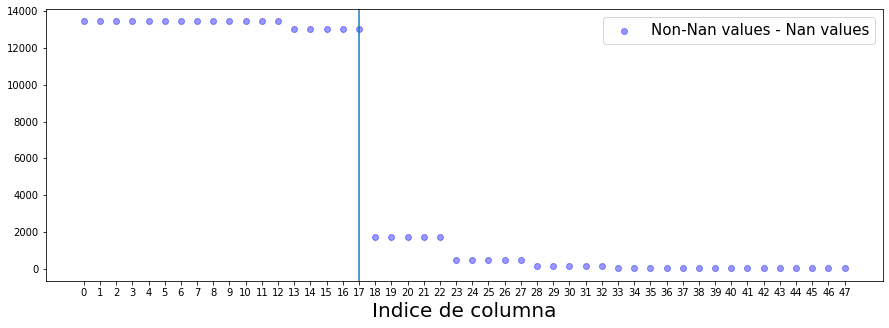

In [103]:
col = df_csnv.columns.values
contador = []
for i in col:
    suma = pd.isnull(df_csnv[i]).values.ravel().sum()  # Contamos las variables Nulas (Nan)
    contador.append(df_csnv.shape[0]-suma)
x = range(len(col))
plt.figure(figsize=(15, 5))
plt.scatter(x, contador, c='b', alpha=0.4)
plt.legend(['Non-Nan values - Nan values'], fontsize=11, prop={'size': 15})
plt.xlabel('Indice de columna', fontsize=20)
plt.axvline(x=17)
plt.xticks(np.arange(0, 48, 1))
plt.show()

Eliminamos desde la columna 18 en adelante

In [104]:
zone_name = ['Zone Name (%s)'%x for x in range(3,9)]
zone_start = ['Zone Start (%s)'%x for x in range(3,9)]
zone_end = ['Zone End (%s)'%x for x in range(3,9)]
zone_time = ['Zone Time (%s)'%x for x in range(3,9)]
zone_pretime = ['Zone Pre Time (%s)'%x for x in range(3,9)]
cols = zone_name + zone_start + zone_end + zone_time + zone_pretime
df_csnv=df_csnv.drop(cols,axis=1)
df_csnv

Year [In]  Month [In]  Day [In]  Hour [In]  Year [Out]  Month [Out]  \
3           2019           7         1          0        2019            7   
4           2019           7         1          0        2019            7   
6           2019           7         1          0        2019            7   
7           2019           7         1          1        2019            7   
10          2019           7         1          1        2019            7   
...          ...         ...       ...        ...         ...          ...   
95147       2020           6         7         20        2020            6   
95170       2020           6         7         21        2020            6   
95186       2020           6         7         22        2020            6   
95197       2020           6         8          0        2020            6   
95207       2020           6         8          0        2020            6   

       Day [Out]  Hour [Out]   Zone Name (1)  Zone Pre Time (1)  \
3              1           0           C PTS           0.000000   
4              1           0          C NPT3          10.016667   
6              1           1          C NPT3          11.416667   
7              1           1          C NPT3          28.116667   
10             1           2           C PTS          38.016667   
...          ...         ...             ...                ...   
95147          7          21          C NPT3          41.083333   
95170          7          22  Romana Salitre          19.583333   
95186          7          23  Romana Salitre          50.383333   
95197          8           0          C NPT3          11.883333   
95207          8           1          C CS-4          19.166667   

           Zone Start (1)        Zone End (1)  Zone Time (1) Zone Name (2)  \
3     2019-07-01 00:00:09 2019-07-01 00:05:52       5.716667        Salida   
4     2019-07-01 00:41:50 2019-07-01 00:46:50       5.000000        Salida   
6     2019-07-01 01:10:25 2019-07-01 01:15:25       5.000000        Salida   
7     2019-07-01 01:42:00 2019-07-01 01:50:41       8.683333        Salida   
10    2019-07-01 02:06:38 2019-07-01 02:11:20       4.700000        Salida   
...                   ...                 ...            ...           ...   
95147 2020-06-07 20:57:09 2020-06-07 21:10:33      13.400000        Salida   
95170 2020-06-07 21:51:57 2020-06-07 21:56:57       5.000000        C NPT4   
95186 2020-06-07 23:24:38 2020-06-07 23:39:54      15.266667        C NPT4   
95197 2020-06-08 00:21:42 2020-06-08 00:26:20       4.633333        Salida   
95207 2020-06-08 01:18:12 2020-06-08 01:27:13       9.016667        Salida   

       Zone Pre Time (2)      Zone Start (2)        Zone End (2)  \
3                    0.0 2019-07-01 00:05:52 2019-07-01 00:10:10   
4                    0.0 2019-07-01 00:46:50 2019-07-01 00:51:50   
6                    0.0 2019-07-01 01:15:25 2019-07-01 01:22:25   
7                    0.0 2019-07-01 01:50:41 2019-07-01 01:56:02   
10                   0.0 2019-07-01 02:11:20 2019-07-01 02:20:39   
...                  ...                 ...                 ...   
95147                0.0 2020-06-07 21:10:33 2020-06-07 21:19:33   
95170              622.0 2020-06-07 22:07:19 2020-06-07 22:17:28   
95186                0.0 2020-06-07 23:39:54 2020-06-07 23:45:33   
95197                0.0 2020-06-08 00:26:20 2020-06-08 00:32:48   
95207                0.0 2020-06-08 01:27:13 2020-06-08 01:34:14   

       Zone Time (2)  
3              258.0  
4              300.0  
6              420.0  
7              321.0  
10             559.0  
...              ...  
95147          540.0  
95170          609.0  
95186          339.0  
95197          388.0  
95207          421.0  

[13446 rows x 18 columns]

Consideramos ahora solo la que tienen por nombre Salida en su ZO(2)

In [6]:
df_csnv=df_csnv.loc[lambda df: df["Zone Name (2)"]=='Salida']
df_csnv

Year [In]  Month [In]  Day [In]  Hour [In]  Year [Out]  Month [Out]  \
3           2019           7         1          0        2019            7   
4           2019           7         1          0        2019            7   
6           2019           7         1          0        2019            7   
7           2019           7         1          1        2019            7   
10          2019           7         1          1        2019            7   
...          ...         ...       ...        ...         ...          ...   
95143       2020           6         7         19        2020            6   
95146       2020           6         7         20        2020            6   
95147       2020           6         7         20        2020            6   
95197       2020           6         8          0        2020            6   
95207       2020           6         8          0        2020            6   

       Day [Out]  Hour [Out] Zone Name (1)  Zone Pre Time (1)  \
3              1           0         C PTS           0.000000   
4              1           0        C NPT3          10.016667   
6              1           1        C NPT3          11.416667   
7              1           1        C NPT3          28.116667   
10             1           2         C PTS          38.016667   
...          ...         ...           ...                ...   
95143          7          20        C NPT3          43.133333   
95146          7          21        C NPT3          32.833333   
95147          7          21        C NPT3          41.083333   
95197          8           0        C NPT3          11.883333   
95207          8           1        C CS-4          19.166667   

          Zone Start (1)       Zone End (1)  Zone Time (1) Zone Name (2)  \
3      20190701 00:00:09  20190701 00:05:52       5.716667        Salida   
4      20190701 00:41:50  20190701 00:46:50       5.000000        Salida   
6      20190701 01:10:25  20190701 01:15:25       5.000000        Salida   
7      20190701 01:42:00  20190701 01:50:41       8.683333        Salida   
10     20190701 02:06:38  20190701 02:11:20       4.700000        Salida   
...                  ...                ...            ...           ...   
95143  20200607 20:36:57  20200607 20:43:40       6.716667        Salida   
95146  20200607 20:44:05  20200607 20:52:06       8.016667        Salida   
95147  20200607 20:57:09  20200607 21:10:33      13.400000        Salida   
95197  20200608 00:21:42  20200608 00:26:20       4.633333        Salida   
95207  20200608 01:18:12  20200608 01:27:13       9.016667        Salida   

       Zone Pre Time (2)     Zone Start (2)       Zone End (2)  Zone Time (2)  
3                    0.0  20190701 00:05:52  20190701 00:10:10          258.0  
4                    0.0  20190701 00:46:50  20190701 00:51:50          300.0  
6                    0.0  20190701 01:15:25  20190701 01:22:25          420.0  
7                    0.0  20190701 01:50:41  20190701 01:56:02          321.0  
10                   0.0  20190701 02:11:20  20190701 02:20:39          559.0  
...                  ...                ...                ...            ...  
95143                0.0  20200607 20:43:40  20200607 20:52:39          539.0  
95146                0.0  20200607 20:52:06  20200607 21:04:05          719.0  
95147                0.0  20200607 21:10:33  20200607 21:19:33          540.0  
95197                0.0  20200608 00:26:20  20200608 00:32:48          388.0  
95207                0.0  20200608 01:27:13  20200608 01:34:14          421.0  

[11300 rows x 18 columns]

Haremos un Groupby por Nombre de zona y su hora, para obtener estadísticos específicos para este trayecto en particular

In [76]:
df_aux=df_csnv.groupby(['Zone Name (1)', 'Hour [In]']).agg(
    tiempo_promedio=pd.NamedAgg(column='Zone Time (1)', aggfunc=np.mean),
    camiones=pd.NamedAgg(column='Zone Time (1)', aggfunc='count'),
    tiempo_min=pd.NamedAgg(column='Zone Time (1)', aggfunc='min'),
    tiempo_total=pd.NamedAgg(column='Zone Time (1)', aggfunc='sum'),
    tiempo_max=pd.NamedAgg(column='Zone Time (1)', aggfunc='max'),
    #hora=pd.NamedAgg(column='Hour [In]', aggfunc='first')
    pretime_prom=pd.NamedAgg(column='Zone Pre Time (1)', aggfunc=np.mean),
    pretime_min=pd.NamedAgg(column='Zone Pre Time (1)', aggfunc='min'),
    pretime_max=pd.NamedAgg(column='Zone Pre Time (1)', aggfunc='max'),
    pretime_total=pd.NamedAgg(column='Zone Pre Time (1)', aggfunc='sum')
)
df_aux.loc["C NPT3"]

tiempo_promedio  camiones  tiempo_min  tiempo_total  tiempo_max  \
Hour [In]                                                                    
0                 6.244583       280    3.000000   1748.483333   28.333333   
1                 6.271333       275    3.000000   1724.616667   23.950000   
2                 5.834673       224    2.000000   1306.966667   25.033333   
3                 6.449143       175    2.983333   1128.600000   14.016667   
4                 6.168908       119    3.983333    734.100000   14.983333   
5                 6.525538       248    2.166667   1618.333333   41.016667   
6                 6.629322       295    3.000000   1955.650000   17.983333   
7                 6.751579       285    2.016667   1924.200000   25.466667   
8                 7.193200       424    2.000000   3049.916667   24.066667   
9                 7.221396       370    2.000000   2671.916667   24.983333   
10                7.562226       274    2.000000   2072.050000   33.516667   
11                6.996954       487    2.983333   3407.516667   32.900000   
12                6.823795       505    2.000000   3446.016667   32.966667   
13                7.032626       424    2.000000   2981.833333   25.000000   
14                7.189594       394    2.516667   2832.700000   94.916667   
15                6.631916       388    2.016667   2573.183333   23.883333   
16                6.589731       396    2.983333   2609.533333   23.000000   
17                6.783613       476    2.016667   3229.000000   24.666667   
18                6.809412       448    2.050000   3050.616667   30.566667   
19                6.820758       387    2.000000   2639.633333   47.616667   
20                7.277601       314    3.000000   2285.166667   27.000000   
21                7.159919       247    2.000000   1768.500000   25.033333   
22                7.003117       123    3.000000    861.383333   21.716667   
23                6.301865       277    3.000000   1745.616667   26.100000   

           pretime_prom  pretime_min  pretime_max  pretime_total  
Hour [In]                                                         
0             31.669226    10.000000   179.450000    8867.383333  
1             30.131879     9.066667   304.200000    8286.266667  
2             26.360565     8.166667   107.183333    5904.766667  
3             23.626286     9.966667   238.033333    4134.600000  
4             19.030952     8.966667    63.433333    2264.683333  
5             28.846169     9.016667   163.600000    7153.850000  
6             38.176893     9.166667   331.600000   11262.183333  
7             72.130409     9.633333   362.166667   20557.166667  
8             63.590566     8.000000   379.333333   26962.400000  
9             69.201937    10.016667   421.650000   25604.716667  
10            52.882482    10.183333   309.800000   14489.800000  
11            50.498871    10.233333   326.550000   24592.950000  
12            64.023564     0.000000   330.166667   32331.900000  
13            67.900118     5.066667   330.000000   28789.650000  
14            66.781810     9.983333   417.983333   26312.033333  
15            65.130713    10.683333   938.500000   25270.716667  
16            65.780808     2.683333   885.800000   26049.200000  
17            65.571218    11.033333   727.350000   31211.900000  
18            76.705952    10.000000   649.016667   34364.266667  
19           102.186434     9.783333   809.450000   39546.150000  
20            89.469055     4.650000   571.583333   28093.283333  
21            78.894602    10.016667   689.100000   19486.966667  
22            51.657724    10.166667   640.433333    6353.900000  
23            35.434477     9.983333   329.183333    9815.350000

In [61]:
def plots_by_zone(zone,status):
    if status == "atencion":
        figure, axes = plt.subplots(nrows=2, ncols=2)
        df_aux.loc[zone].plot(y="tiempo_total",use_index=True,kind='bar',ax=axes[0,0],figsize=(10,7))
        df_aux.loc[zone].plot(y="tiempo_promedio",use_index=True,kind='line',xticks=np.arange(0,24,1),ax=axes[0,1])
        df_aux.loc[zone].plot(y="tiempo_min",use_index=True,kind='line',xticks=np.arange(0,24,1),ax=axes[1,0])
        df_aux.loc[zone].plot(y="tiempo_max",use_index=True,kind='line',xticks=np.arange(0,24,1),ax=axes[1,1])
        figure.tight_layout()    
    elif status == "espera":
        figure, axes = plt.subplots(nrows=2, ncols=2)
        df_aux.loc[zone].plot(y="pretime_total",use_index=True,kind='bar',ax=axes[0,0],figsize=(10,7))
        df_aux.loc[zone].plot(y="pretime_prom",use_index=True,kind='line',xticks=np.arange(0,24,1),ax=axes[0,1])
        df_aux.loc[zone].plot(y="pretime_min",use_index=True,kind='line',xticks=np.arange(0,24,1),ax=axes[1,0])
        df_aux.loc[zone].plot(y="pretime_max",use_index=True,kind='line',xticks=np.arange(0,24,1),ax=axes[1,1])
        figure.tight_layout()
    elif status == "camion":
        df_aux.loc[zone].plot(y="camiones",use_index=True,kind='bar')


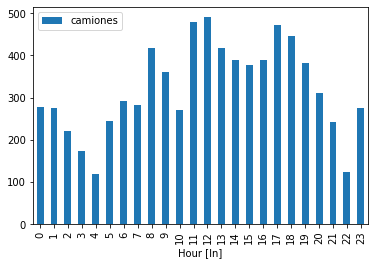

In [63]:
plots_by_zone("C NPT3","camion")

En este plot hay alrededor de 8000 datos. de los 11.300 que existen en el dataset, los demas se distribuyen en las demás zonas.

__Tiempos de Atención__

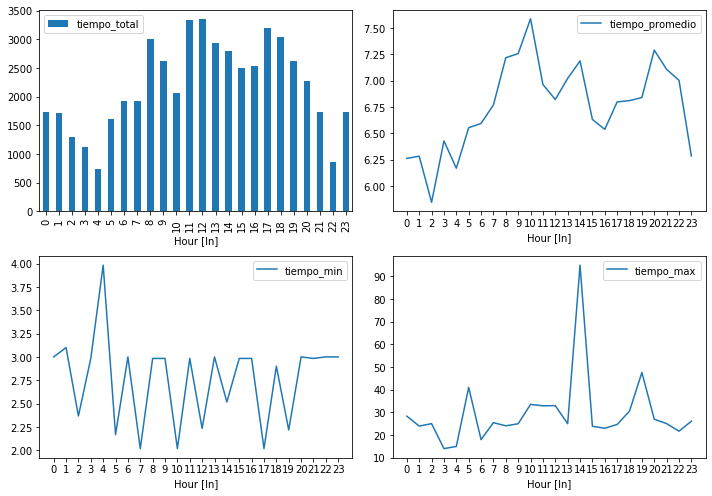

In [65]:
plots_by_zone("C NPT3", "atencion")

__Tiempos de Espera__

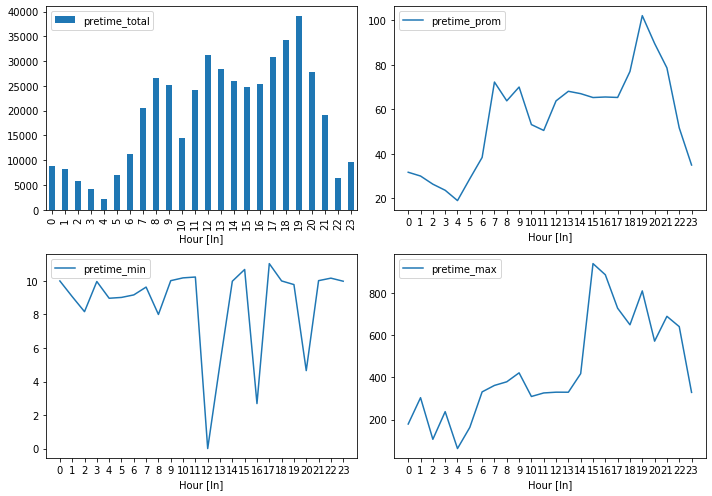

In [66]:
plots_by_zone("C NPT3", "espera")

Veamos otra zona, la __C PTS__ por ejemplo

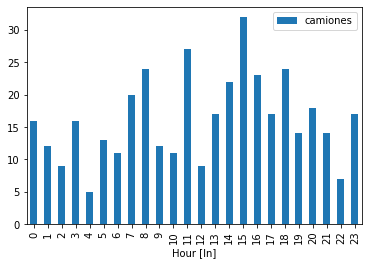

In [67]:
plots_by_zone("C PTS","camion")

__Tiempo Atención__

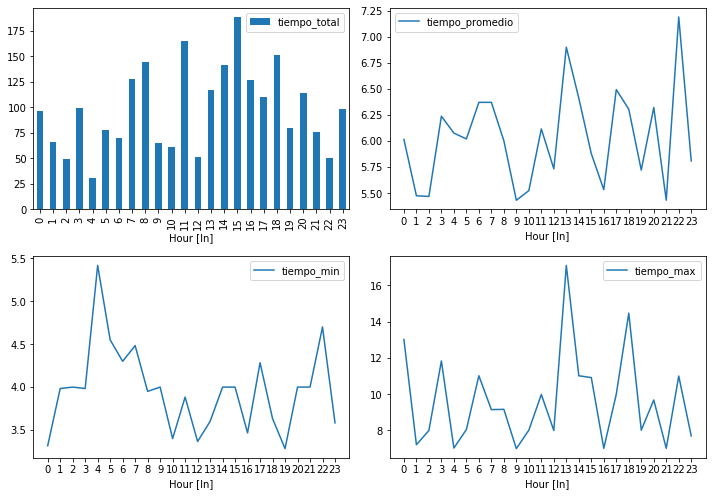

In [71]:
zona ="C PTS"
plots_by_zone(zona,"atencion")

__Tiempo Espera__

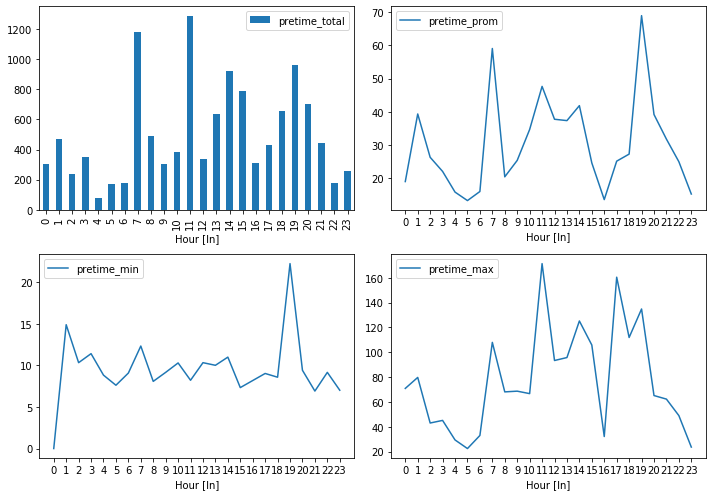

In [74]:
plots_by_zone(zona,"espera")